In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from time import time
from decimal import Decimal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Import training data - FG only

In [2]:
### normal
tic = time()

n_signals = pd.read_excel('./Training/FG_normal/FG_normal_ATData.xlsx')
n_bubble_detect = pd.read_excel('./Training/FG_normal/FG_normal_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 152.636s


In [3]:
### ref bubbles
tic = time()

rb_signals = pd.read_excel('./Training/FG_bubbles/FG_ref_bubbles_ATData.xlsx')
rb_bubble_detect = pd.read_excel('./Training/FG_bubbles/FG_ref_bubbles_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 4.880s


# Create test objects and dataframe

In [4]:
class Test:
    def __init__(self, ID, BubbleDetectTime, P4, P5, A4):
        self.ID = ID
        self.BubbleDetectTime = BubbleDetectTime
        self.P4 = P4 # potassium
        self.P5 = P5 # calcium
        self.A4 = A4 # crea
        
    # function to offset t = 0
    def offset_time(self):
        # using Decimal due to rounding error
        t_0 = Decimal(str(self.BubbleDetectTime + 30))
        t_step = Decimal(str(0.2))
        start_idx = round(t_0/t_step) - 1
                
        self.P4 = self.P4[start_idx:]
        self.P5 = self.P5[start_idx:]
        self.A4 = self.A4[start_idx:]
        
    # function to trim NaNs
    def trim_NaNs(self):
        # making sure list is not empty
        while len(self.P4) > 0 and math.isnan(self.P4[-1]):
            self.P4.pop()
                
        while len(self.P5) > 0 and math.isnan(self.P5[-1]):
            self.P5.pop()
        
        while len(self.A4) > 0 and math.isnan(self.A4[-1]):
            self.A4.pop()
            

def create_test_list(signals, bubble_detect_time):
    # separating channels
    group_channels = signals.groupby('Channel')
    channel_dfs = {}

    # iterating over the groups and creating a new dataframe for each group
    for channel, group in group_channels:
        df = pd.DataFrame(group.iloc[:, 2:])
        channel_dfs[channel] = df

    # creating test objects
    tests = []
    for i in range(0, len(bubble_detect_time)):
        ID = bubble_detect_time.iloc[i, 0]
        BubbleDetectTime = bubble_detect_time.iloc[i, 1]
        P4 = channel_dfs['P4'].iloc[i, :].values.tolist()
        P5 = channel_dfs['P5'].iloc[i, :].values.tolist()
        A4 = channel_dfs['A4'].iloc[i, :].values.tolist()

        new_test = Test(ID, BubbleDetectTime, P4, P5, A4)
        tests.append(new_test)
    
    return tests

In [92]:
### making test objects for each test type
labels = ["Normal", "Ref bubble"]
signals = [n_signals, rb_signals]
bubble_detect_times = [n_bubble_detect, rb_bubble_detect]

test_dict = {}

for label, signal, bubble_detect_time in zip(labels, signals, bubble_detect_times):
    test_dict[label] = create_test_list(signal, bubble_detect_time)

### offset and trim all tests
for test_type in test_dict.values():
    for idx, test in enumerate(test_type): 
        test.offset_time()
        test.trim_NaNs()
        
n_tests = test_dict["Normal"]
rb_tests = test_dict["Ref bubble"]

In [93]:
print(len(n_tests))
print(len(rb_tests))

3128
106


# Filtering for pipeline condition

In [7]:
def short_peaks(test, size):
    if size == 0:
        # checking for valleys
        peaks_1, _ = find_peaks(-1 * np.array(test.P4))

        # checking for peaks
        peaks_2, _ = find_peaks(np.array(test.P4))

        # merging valleys and peaks
        peaks = np.concatenate((peaks_1, peaks_2))

        if len(peaks) >= 80:  # normal
            return 1
        else:  # undetermined
            return 0

    elif size == 10:
        # checking for valleys
        peaks_1, _ = find_peaks(-1 * np.array(test.P4), width=size)

        # checking for peaks
        peaks_2, _ = find_peaks(np.array(test.P4), width=size)

        # merging valleys and peaks
        peaks = np.concatenate((peaks_1, peaks_2))

        if len(peaks) >= 3:  # ref bubble
            return 1
        else:  # undetermined
            return 0

In [94]:
# finding peaks in normal and ref bubbles
labels = ['Normal', 'Ref bubble']
tests = {'Normal': n_tests, 'Ref bubble': rb_tests} # dict of test objects
targets = {'Normal': [], 'Ref bubble': []} # dict of tests that are accepted under pipeline condition

# filtering
for label in labels:
    for idx, test in enumerate(tests[label]):
        if (short_peaks(test, 0) == 0) & (short_peaks(test, 10) == 0):
            targets[label].append(tests[label][idx]) # append test object not idx
        
print(len(targets['Normal']))
print(len(targets['Ref bubble']))

for label in labels:
    tests[label] = [test for test in tests[label] if test in targets[label]]
    
print(len(tests['Normal']))
print(len(tests['Ref bubble']))

1918
37
1918
37


In [95]:
### labelling tests

# creating new dataframes with class for each test - note: this makes the value type np.int32
n_df = pd.DataFrame({'Test': tests['Normal'], 'Class': np.repeat(0, len(tests['Normal'])), 'Predicted': ''})
rb_df = pd.DataFrame({'Test': tests['Ref bubble'], 'Class': np.repeat(1, len(tests['Ref bubble'])), 'Predicted': ''})

# concatenating
test_df = pd.concat([n_df, rb_df]).reset_index(drop=True)

In [84]:
print(len(test_df[test_df['Class'] == 0]))
print(len(test_df[test_df['Class'] == 1]))

1918
37


# Function fitting functions - BULK TESTS

In [96]:
# define the linear function to fit
def lin_func(x, a, b):
    return a*x + b


# fit data to linear curve for one test
def fit_lin(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(lin_func, x, y)
    y_fit = lin_func(x, *popt) # unpacks tuple into the 2 coefficients rather than passing an array

    return x, y, y_fit, popt
    
    
def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared

# Function fitting functions - SINGLE TEST (for predictions)

In [98]:
# define the linear function to fit
def lin_func(x, a, b):
    return a*x + b


# fit data to linear curve for one test
def fit_lin(test):
    y = test.P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(lin_func, x, y)
    y_fit = lin_func(x, *popt) # unpacks tuple into the 2 coefficients rather than passing an array

    return x, y, y_fit, popt


def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared

# Getting all R-squared values

In [97]:
### fitting normal tests to polynomial/linear functions
x_list = {'Normal': [], 'Ref bubble': []}
y_list = {'Normal': [], 'Ref bubble': []}
y_fit_list = {'Normal': [], 'Ref bubble': []}
coef_list = {'Normal': [], 'Ref bubble': []}

# extracting all test objects to list
# why am i making a joint test_df just to split them up again? idk
tests['Normal'] = test_df[test_df['Class'] == 0]['Test'].to_list() 
tests['Ref bubble'] = test_df[test_df['Class'] == 1]['Test'].to_list() 

for label in labels:
    for idx, _ in enumerate(tests[label]):
        x, y, y_fit, coef = fit_lin(idx, tests[label])
        x_list[label].append(x)
        y_list[label].append(y)
        y_fit_list[label].append(y_fit)
        coef_list[label].append(coef)
    
### computing R-squared values to evaluate fit
rs_list = {'Normal': [], 'Ref bubble': []}

for label in labels:
    for y, y_fit in zip(y_list[label], y_fit_list[label]):
        rs_list[label].append(compute_residuals(y, y_fit))
    
    rs_list[label].sort()

In [23]:
for r_squared in rs_list['Ref bubble']:
    print(f"R-squared: {r_squared:.4f}")

R-squared: 0.0157
R-squared: 0.0692
R-squared: 0.0697
R-squared: 0.1327
R-squared: 0.1815
R-squared: 0.3258
R-squared: 0.3336
R-squared: 0.6126
R-squared: 0.6305
R-squared: 0.6924
R-squared: 0.7142
R-squared: 0.7400
R-squared: 0.7740
R-squared: 0.8299
R-squared: 0.8543
R-squared: 0.8557
R-squared: 0.8744
R-squared: 0.8987
R-squared: 0.9214
R-squared: 0.9386
R-squared: 0.9498
R-squared: 0.9534
R-squared: 0.9587
R-squared: 0.9592
R-squared: 0.9632
R-squared: 0.9655
R-squared: 0.9679
R-squared: 0.9700
R-squared: 0.9714
R-squared: 0.9740
R-squared: 0.9794
R-squared: 0.9800
R-squared: 0.9878
R-squared: 0.9883
R-squared: 0.9892
R-squared: 0.9949
R-squared: 0.9959


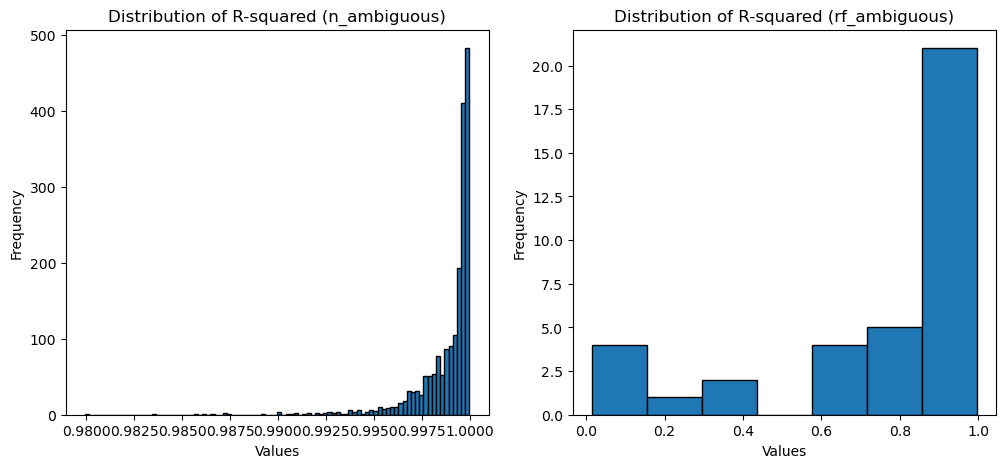

In [17]:
"""# plotting distribution of R-squared
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].hist(rs_list['Normal'], bins='auto', edgecolor='black')
axs[1].hist(rs_list['Ref bubble'], bins='auto', edgecolor='black')

# normal
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of R-squared (n_ambiguous)')

# ref failure
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of R-squared (rf_ambiguous)')

# show the plot
plt.show()"""

# For the following two blocks, only run once

In [18]:
# calculating medians and MADS
n_median = np.median(rs_list['Normal'])
rb_median = np.median(rs_list['Ref bubble'])

# only used for visualizing distribution
# n_MAD = np.median(np.abs(rs_list['Normal'] - n_median))
# rb_MAD = np.median(np.abs(rs_list['Ref bubble'] - rb_median))

print(n_median)
print(rb_median)

0.9994838406575157
0.9213536783468436


In [63]:
# testing effects of moving the soft threshold
test_threshold = [0.9800, 0.9825, 0.9850, 0.9875, 0.9900, 0.9925, 0.9950] # min normal = 0.9800, max ref bubble = 0.9960
results = {'Normal': [], 'Ref bubble': []}
bounds = {'Normal': [], 'Ref bubble': []} # lower bound for normal, upper bound for ref bubble

for threshold in test_threshold:
    # normal
    n_dist_med = []
    for rs in rs_list['Normal']:
        if rs < threshold:
            n_dist_med.append(n_median - rs)
            
    median_n_dist_med = np.median(n_dist_med)
    results['Normal'].append(median_n_dist_med)
    bounds['Normal'].append(n_median - median_n_dist_med)
    
    # ref bubble
    rb_dist_med = []
    for rs in rs_list['Ref bubble']:
        if rs >= threshold:
            rb_dist_med.append(rs - rb_median)
            
    median_rb_dist_med = np.median(rb_dist_med)
    results['Ref bubble'].append(median_rb_dist_med)
    bounds['Ref bubble'].append(rb_median + median_rb_dist_med)
    
for lower, upper in zip(bounds['Normal'], bounds['Ref bubble']):
    print(f"Range = [{lower:.6f}, {upper:.6f}], width = {(upper - lower):.6f}")

Range = [0.979945, 0.989249], width = 0.009304
Range = [0.979945, 0.989249], width = 0.009304
Range = [0.981740, 0.989249], width = 0.007509
Range = [0.986364, 0.989249], width = 0.002885
Range = [0.986558, 0.995385], width = 0.008826
Range = [0.990151, 0.995385], width = 0.005234
Range = [0.993149, 0.995887], width = 0.002737


# Predictions and evaluation

In [99]:
"""
- tempted to take the range with the smallest width, but the second smallest width actually contains the original threshold,
so i'm hoping the classification accuracy would be similar but i will compare both
"""
# lists to store R-squared values that fall in ambiguous region
n_ambiguous = []
rb_ambiguous = []

# upper and lower bounds from above
upper = 0.989249
lower = 0.979945

for idx, test in enumerate(test_df['Test']):
    # fit to linear function
    x, y, y_fit, popt = fit_lin(test)

    # compute R-squared value
    r_squared = compute_residuals(y, y_fit)
    
    """# hard threshold
    if r_squared >= 0.9800:
        test_df.loc[idx, 'Predicted'] = 0 # normal
    else:
        test_df.loc[idx, 'Predicted'] = 1 # ref bubble"""
    
    # soft threshold?
    if r_squared > upper: # upper bound
        test_df.loc[idx, 'Predicted'] = 0 # normal
        # print(f"Class: {test_df.loc[idx, 'Class']}, R-squared: {r_squared}, Predicted: 0")
    elif r_squared < lower: # lower bound
        test_df.loc[idx, 'Predicted'] = 1 # ref bubble
        # print(f"Class: {test_df.loc[idx, 'Class']}, R-squared: {r_squared}, Predicted: 1")
    else: # in between
        test_df.loc[idx, 'Predicted'] = -1 # ambiguous
        
        if test_df.loc[idx, 'Class'] == 0:
            n_ambiguous.append(r_squared)
        elif test_df.loc[idx, 'Class'] == 1:
            rb_ambiguous.append(r_squared)
        
        # print(f"Class: {test_df.loc[idx, 'Class']}, R-squared: {r_squared:.4f}, Predicted: -1")
        
test_df['Predicted'] = test_df['Predicted'].astype(np.int32)

print(len(n_ambiguous))
print(len(rb_ambiguous))

8
4


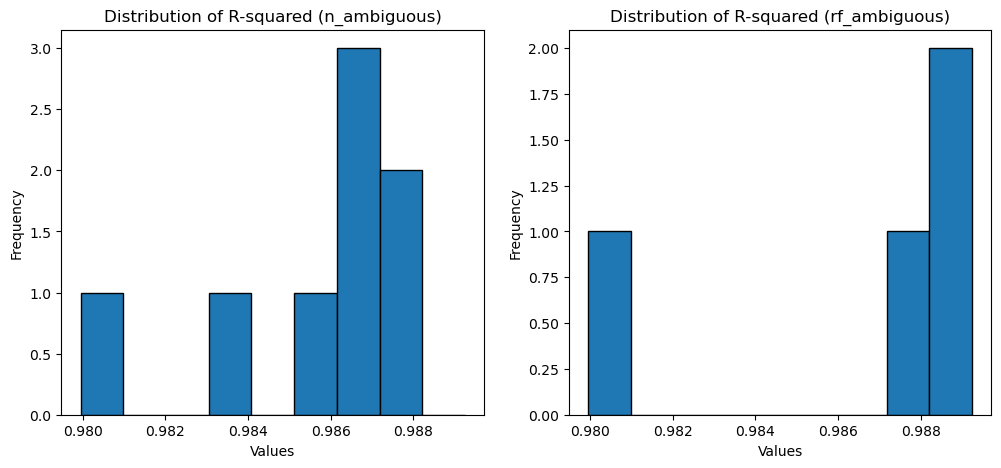

In [100]:
# plotting distribution of ambiguous R-squared
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

edges = np.linspace(lower, upper, 10)

axs[0].hist(n_ambiguous, bins=edges, edgecolor='black')
axs[1].hist(rb_ambiguous, bins=edges, edgecolor='black')

# normal
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of R-squared (n_ambiguous)')

# ref failure
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of R-squared (rf_ambiguous)')

# show the plot
plt.show()

In [101]:
# removing ambiguous tests to calculate accuracy of non-ambiguous tests
print(len(test_df))

mask = test_df['Predicted'] == -1
test_df.drop(index=test_df[mask].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(len(test_df))

1955
1943


In [102]:
from sklearn.metrics import confusion_matrix, classification_report
tn, fp, fn, tp = confusion_matrix(test_df['Class'], test_df['Predicted']).ravel()

print(tn)
print(fp)
print(fn)
print(tp)

print(classification_report(test_df['Class'], test_df['Predicted'], target_names=labels))

1910
0
2
31
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1910
  Ref bubble       1.00      0.94      0.97        33

    accuracy                           1.00      1943
   macro avg       1.00      0.97      0.98      1943
weighted avg       1.00      1.00      1.00      1943

